In [45]:
from Training import DataCreateUpdated as dc
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import random

# rec_paths = ["OpenBCI-RAW-2021-12-02_19-19-53.txt", 
#                 "OpenBCI-RAW-2021-12-02_19-31-12.txt", 
#                 "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_JawClench_2\OpenBCI-RAW-2022-02-16_19-30-28.txt",
#                 "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_LeftBlink_1\OpenBCI-RAW-2022-02-16_19-33-20.txt",
#                 "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_LeftBlink_2\OpenBCI-RAW-2022-02-16_19-39-23.txt",
#                 "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_RightBlink_1\OpenBCI-RAW-2022-02-16_19-42-03.txt"]
# label_paths = ["JawClench_labels_Ansh_12-02-21-1918.txt", 
#                 "JawClench_labels_Ansh_12-02-21-1930.txt", 
#                 "Recordings\Spring_2022\Evan_JawClench_1.txt",
#                 "Recordings\Spring_2022\Evan_LeftBlink_1.txt",
#                 "Recordings\Spring_2022\Evan_LeftBlink_2.txt",
#                 "Recordings\Spring_2022\Evan_RightBlink_1.txt"]
# label_types = ["JAW_CLENCH", 
#                 "JAW_CLENCH", 
#                 "JAW_CLENCH",
#                 "L_EYE",
#                 "L_EYE",
#                 "R_EYE"]


rec_paths = ["Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowLower_2\OpenBCI-RAW-2022-03-23_20-43-17.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowLower_1\OpenBCI-RAW-2022-03-23_20-41-22.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowRaise_1\OpenBCI-RAW-2022-03-23_20-37-06.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowRaise_2\OpenBCI-RAW-2022-03-23_20-39-04.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_JawClench_1\OpenBCI-RAW-2022-03-23_20-33-09.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_JawClench_2\OpenBCI-RAW-2022-03-23_20-34-58.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_LeftEye_1\OpenBCI-RAW-2022-03-23_20-21-37.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_LeftEye_2\OpenBCI-RAW-2022-03-23_20-25-30.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_RightEye_1\OpenBCI-RAW-2022-03-23_20-27-22.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_RightEye_2\OpenBCI-RAW-2022-03-23_20-29-16.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowLower_1\OpenBCI-RAW-2022-03-26_18-33-15.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowLower_2\OpenBCI-RAW-2022-03-26_18-35-00.txt",
            # "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowRaise_1\OpenBCI-RAW-2022-03-26_18-38-07.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowRaise_2\OpenBCI-RAW-2022-03-26_18-39-58.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_JawClench_1\OpenBCI-RAW-2022-03-26_18-21-33.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_JawClench_2\OpenBCI-RAW-2022-03-26_18-23-24.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_LeftBlink_1\OpenBCI-RAW-2022-03-26_18-25-33.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_LeftBlink_2\OpenBCI-RAW-2022-03-26_18-30-33.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_RightBlink_1\OpenBCI-RAW-2022-03-26_18-04-32.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_RightBlink_2\OpenBCI-RAW-2022-03-26_18-07-12.txt"]

label_paths = ["Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowLower_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowLower_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowRaise_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_BrowRaise_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_JawClench_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_JawClench_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_LeftEye_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_LeftEye_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_RightEye_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-23_Sam_RightEye_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowLower_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowLower_2\labels.txt",
            # "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowRaise_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_BrowRaise_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_JawClench_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_JawClench_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_LeftBlink_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_LeftBlink_2\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_RightBlink_1\labels.txt",
            "Recordings\Spring_2022\OpenBCISession_2022-03-26_Sam_RightBlink_2\labels.txt"]

label_types = ["BROW_DOWN", "BROW_DOWN", "BROW_UP", "BROW_UP", "JAW_CLENCH", "JAW_CLENCH", "L_EYE", "L_EYE", "R_EYE", "R_EYE", "BROW_DOWN", "BROW_DOWN", "BROW_UP", "JAW_CLENCH", "JAW_CLENCH", "L_EYE", "L_EYE", "R_EYE", "R_EYE"]

#Chooses which input data to use
inputsToUse = np.arange(len(rec_paths))

In [46]:
# Data visualization for the sample data at index sdi
# Go to next block for actual code
def visualize_data(sdi):
    sample_obs = dc.getObservations(rec_paths[sdi], label_paths[sdi], 1000, [0,1,2,3], label_types[sdi])

    sample_y_channels_groups, sample_ind_groups, sample_t_groups, sample_l_groups = sample_obs
    
    na_ind = 0 #non-action
    a_ind = 0 #action

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.xlabel('mean_abs_dev')
    plt.ylabel('channel')

    colorgood = 'blue'
    colorbad = 'red'
    pos = -1
    for channel_groups in sample_y_channels_groups:
        pos = (pos+1)%4
        for i in range(channel_groups.shape[0]):
            if(sample_l_groups[i][0] == 1):
                color = colorbad
                if(random.randint(0, 2*na_ind) < 1):
                    na_ind = i
            else:
                color = colorgood
                if(random.randint(0, 2*a_ind) < 1):
                    a_ind = i
            plt.plot(np.mean(np.abs(channel_groups[i] - np.ones_like(channel_groups[i]) * np.mean(channel_groups[i]))), pos, 'x', color = color)
    
    plt.subplot(1,3,2)
    plt.xlabel('index - Action: ' + str(a_ind))
    plt.ylabel('voltage')
    plt.ylim(0, 2500)
    for channel_groups in sample_y_channels_groups:
        plt.plot(sample_ind_groups[a_ind], channel_groups[a_ind])


    plt.subplot(1,3,3)
    plt.xlabel('index - No Action: ' + str(na_ind))
    plt.ylabel('voltage')
    plt.ylim(0, 2500)
    for channel_groups in sample_y_channels_groups:
        plt.plot(sample_ind_groups[na_ind], channel_groups[na_ind])

In [47]:
# for input in inputsToUse:
#     visualize_data(input)

In [48]:
def getMeanAbsDeviation(dchannel):
    return np.transpose(np.mean(np.abs(dchannel - np.mean(dchannel, axis=2, keepdims=True)), axis=2))

def getMeanSquaredDeviation(dchannel):
    return np.transpose(np.mean(np.square(dchannel - np.mean(dchannel, axis=2, keepdims=True)), axis=2))

def getMean(dchannel):
    return np.transpose(np.mean(dchannel, axis=2))

def getPercentile(dchannel, percent):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile10(dchannel, percent=10):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile90(dchannel, percent=90):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile15(dchannel, percent=15):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile85(dchannel, percent=85):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile5(dchannel, percent=5):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getPercentile95(dchannel, percent=95):
    return np.transpose(np.percentile(dchannel, percent, axis=2))


def getSpread(dchannel):
    return np.transpose(np.max(dchannel, axis=2) - np.min(dchannel, axis=2))

def getSpreadPercentile(dchannel, low=5, high=95):
    return getPercentile(dchannel, high) - getPercentile(dchannel, low)

def getPeakCount(dchannel, w=3):
    ret = np.zeros((dchannel.shape[1], dchannel.shape[0]))
    for ch in range(dchannel.shape[0]):
        for sample in range(dchannel.shape[1]):
            count = 0
            for tind in range(w, dchannel.shape[2]-w):
                isPeak = True
                for x in range(1, w+1):
                    isPeak &= (dchannel[ch, sample, tind] > dchannel[ch, sample, tind-x] and dchannel[ch, sample, tind] > dchannel[ch, sample, tind+x])
                if(isPeak):
                    count+=1
            ret[sample, ch] = count
    return ret

def getPeakCount5(dchannel, w=5):
    ret = np.zeros((dchannel.shape[1], dchannel.shape[0]))
    for ch in range(dchannel.shape[0]):
        for sample in range(dchannel.shape[1]):
            count = 0
            for tind in range(w, dchannel.shape[2]-w):
                isPeak = True
                for x in range(1, w+1):
                    isPeak &= (dchannel[ch, sample, tind] > dchannel[ch, sample, tind-x] and dchannel[ch, sample, tind] > dchannel[ch, sample, tind+x])
                if(isPeak):
                    count+=1
            ret[sample, ch] = count
    return ret

def getPeakCount1(dchannel, w=1):
    ret = np.zeros((dchannel.shape[1], dchannel.shape[0]))
    for ch in range(dchannel.shape[0]):
        for sample in range(dchannel.shape[1]):
            count = 0
            for tind in range(w, dchannel.shape[2]-w):
                isPeak = True
                for x in range(1, w+1):
                    isPeak &= (dchannel[ch, sample, tind] > dchannel[ch, sample, tind-x] and dchannel[ch, sample, tind] > dchannel[ch, sample, tind+x])
                if(isPeak):
                    count+=1
            ret[sample, ch] = count
    return ret

In [49]:
# Loads in X and Y
functsList = [getMean, getMeanSquaredDeviation, getMeanAbsDeviation, getSpreadPercentile, getPeakCount, getPercentile10, getPercentile90]
meanScale = []
stdevScale = []
functsDict = {}
for featureFunc in functsList:
    y = None
    fX = None
    for i in inputsToUse:
        obs = dc.getObservations(rec_paths[i], label_paths[i], 1000, [0,1,2,3], label_types[i])
        y_channels_groups, ind_groups, t_groups, l_groups = obs
        # y_channels_groups = y_channels_groups[:, 5:-5, :]
        # l_groups = l_groups[5:-5, :]
        if fX is not None:
            fX = np.concatenate((fX, featureFunc(y_channels_groups)))
            y = np.concatenate((y, l_groups))
        else:
            fX = featureFunc(y_channels_groups)
            y = l_groups
    mean = np.mean(fX, axis=0)
    stdev = np.std(fX, axis=0)
    meanScale.append(mean)
    stdevScale.append(stdev)
    functsDict[featureFunc] = (fX - mean)/stdev


In [50]:
def createX(fDict, count, fIndices = None):
    X = None
    # featureList = [functsDict[getMean], functsDict[getMeanAbsDeviation]]
    ftotal = []
    fnames = []
    for f in fDict.values():
        ftotal.append(f)
    for f in fDict.keys():
        fnames.append(f)
    if fIndices is None:
        fIndices = random.sample(range(len(ftotal)), count)
    featureList = [ftotal[i] for i in fIndices]
    fnames = [fnames[i] for i in fIndices]
    for feature in featureList:
        if(X is None):
            X = feature
        else:
            X = np.concatenate((X, feature), axis=1)
    return X, fnames

In [51]:
#test-train split

X, find = createX(functsDict, 3)

X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.4, random_state = 4)    

In [52]:
from imblearn.over_sampling import SMOTE

def oversample(X, y):
    X_combined = np.concatenate((X, y), axis=1)
    over_sampler = SMOTE(random_state=4)
    X_combined, _ = over_sampler.fit_resample(X_combined, np.argmax(y, axis=1))
    X_res = X_combined[:, 0:X.shape[1]]
    y_res = X_combined[:, X.shape[1]:X_combined.shape[1]]
    return X_res, y_res



# Under Sampling
from imblearn.under_sampling import RandomUnderSampler
def undersample(X, y):
    X_combined = np.concatenate((X, y), axis=1)
    under_sampler = RandomUnderSampler(sampling_strategy = 'majority', random_state=42)
    # print(X.shape, y.shape)
    X_res, y_res = under_sampler.fit_resample(X_combined, np.argmax(y, axis=1))
    # print(X_res.shape, y_res.shape)
    X = X_res[:, 0:X.shape[1]]
    y = X_res[:, X.shape[1]:X_res.shape[1]]
    return X, y


In [53]:
# from sklearn import svm

def getMetrics(K, X, y, verbose=True, scale = 2, overOrUnder = None):
    X_res, X_eval, y_res, y_eval = train_test_split(X, y, test_size=0.4, random_state = 4)
    action_classifier = KNeighborsClassifier((int)(scale*K) + 1)
    knn_classifier = KNeighborsClassifier(K)
    # action_classifier = svm.SVC()
    # knn_classifier = svm.SVC()
    # print(y_res[:, 0].shape)
    action_classifier.fit(X_res, y_res[:, 0])
    X_res, y_res = undersample(X_res, y_res)
    
    if overOrUnder is not None:
        if not overOrUnder:
            X_eval, y_eval = undersample(X_eval, y_eval)
        else:
            X_eval, y_eval = oversample(X_eval, y_eval)
    knn_classifier.fit(X_res, np.argmax(y_res, axis=1))

    original_pred = knn_classifier.predict(X_eval)
    action_present = action_classifier.predict(X_eval)
    predictions = np.multiply((1-action_present), original_pred)
    # print(original_pred[0:10], action_present[0:10], predictions[0: 10])
    recall = sklearn.metrics.recall_score(np.argmax(y_eval, axis=1), predictions, average=None)
    precision = sklearn.metrics.precision_score(np.argmax(y_eval, axis=1), predictions, average=None, zero_division=0)
    accuracy = sklearn.metrics.accuracy_score(np.argmax(y_eval, axis=1), predictions)
    if(verbose):
        print("Results (KNN): ")
        print("Recall: \t", recall)
        print("Precision: \t", precision)
        print("Accuracy:\t", accuracy)
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(np.argmax(y_eval, axis=1), predictions)
    else:
        return recall, precision, accuracy, knn_classifier, action_classifier

Results (KNN): 
Recall: 	 [0.73633441 0.54019293 0.77491961 0.59807074 0.46623794 0.58199357]
Precision: 	 [0.30250991 0.73043478 0.88602941 0.86511628 0.77956989 0.87864078]
Accuracy:	 0.6162915326902465
[array([93862.20476045,  7523.20183377, 10938.9161295 , 72701.30213732]), array([1105.78098721,  251.60192246, 1193.51012919,  890.36304615]), array([77.96145519, 36.8555236 , 43.23477836, 71.08503054])]
[array([715355.86582232,  30093.86588465,  39312.62294731, 754404.82304548]), array([701.29549086, 239.65263425, 405.58976194, 537.98950971]), array([249.85177453,  61.95052414,  74.49602556, 227.85183245])]


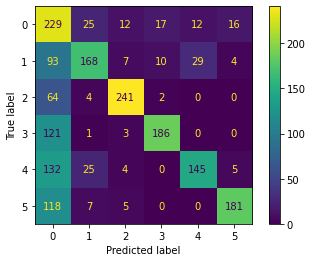

In [56]:
X, find = createX(functsDict, 0, [1, 0, 2])
k = 3
scale = 2.22/k
getMetrics(k, X, y, verbose=True, scale=scale, overOrUnder = True)
_, _, _, kc, ac = getMetrics(k, X, y, verbose=False, scale=scale, overOrUnder = True)

from joblib import dump, load
dump(kc, 'prod_action.joblib') 
dump(ac, 'prod_non_selector.joblib') 
print([meanScale[i] for i in [1, 0, 2]])
print([stdevScale[i] for i in [1, 0, 2]])


In [55]:
countper = 30
bestloss = 0
for cc in range((int)(len(functsList)*countper/1.2)):
    if(cc%50 == 0):
        print(cc)
    X, find = createX(functsDict, cc//countper + 1)

    # X_res, y_res = oversample(X_res, y_res)
    # X_test, y_test = oversample(X_test, y_test)
    accuarr = []
    scales = []
    kvals = []
    prec = []
    rec0 = []
    for kk in range(2):
        for i in range(1, 11, 2):
            scale = 1.25 + np.random.random()
            rec, pre, acc, _, _ = getMetrics(i, X, y, verbose=False, scale=scale)
            accuarr.append(acc)
            scales.append(scale)
            kvals.append(i)
            rec0.append(rec[0])
            prec.append(np.mean(pre[1:]))
    loss_func = np.add(accuarr, rec0)/2
    if(np.max(loss_func) > bestloss):
        bestloss = np.max(loss_func)
        bestacc = accuarr[np.argmax(loss_func)]
        bestX = X
        bestFind = find
        bestScale = scales[np.argmax(loss_func)]
        params = (kvals[np.argmax(loss_func)], bestScale, np.max(loss_func))
        print(params, accuarr[np.argmax(loss_func)])
        # getMetrics(np.argmax(accuarr)+1, X_test, y_test)
        r, p, a, best, best_na = getMetrics(np.argmax(loss_func)+1, X, y, verbose=False, scale=bestScale)

print("Best Accuracy: ", bestacc)
print("Functions: ", bestFind)
print("Hyperparams: ", params)
print("Recall: ", r)
print("Precision: ", p)
getMetrics(params[0], bestX, y, scale=bestScale)


0
(5, 1.7982851785357736, 0.5758032717628558) 0.4635036496350365
(3, 1.6263473026610384, 0.6572687586546812) 0.6167883211678832
(3, 2.037886645525462, 0.665480437486798) 0.6332116788321168
(3, 1.5414969133820067, 0.6980249724223719) 0.6532846715328468
50
(1, 2.2288798775750505, 0.7000228835637337) 0.6733576642335767
(1, 2.1106108057333777, 0.7060195507780411) 0.666058394160584
100
(1, 2.1473924563266458, 0.709886286290985) 0.677007299270073
(1, 2.0688762446418485, 0.7169684558875302) 0.6879562043795621
150


KeyboardInterrupt: 